In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
class ConstantDemand:
    def __init__(self, *, D, E, K):
        self.D = D
        self.E = E
        self.K = K
        self.price_space = np.arange(151)
        self.q_table = {}
        self.v_table = {}
        self.p_table = {}
    
    def get_demand(self, price):
        return self.D * (1 / (1 + ((price/self.K)**(2*self.E))))
    
    def transition_distribution(self, stock, price):
        return TruncatedPoisson(
            mu = model.get_demand(price), 
            K = stock
        )
    
    def unconstrained_optimal_price(self):
        return self.K*((2*self.E - 1)**(-0.5 / self.E))
    
    def q(self, dtg, stock, price):
        r = 0.0
        if dtg*stock:
            if (dtg, stock, price) not in self.q_table.keys():
                sales_dist = self.transition_distribution(stock, price)
                xs = sales_dist.support()
                ps = sales_dist.get_probs()
                for (x, p) in zip(xs, ps):
                    r += p * (price*x + self.v(dtg-1, stock-x))
                self.q_table[(dtg, stock, price)] = r
            else:
                r = self.q_table[(dtg, stock, price)]
        return r
    
    def _optimum(self, dtg, stock):
        index = (dtg, stock)
        qs = [self.q(dtg, stock, price) for price in self.price_space]
        i = np.argmax(qs)
        v, p = qs[i], self.price_space[i]
        self.v_table[index] = v
        self.p_table[index] = p
        return v, p
    
    def v(self, dtg, stock):
        v = 0.0
        if dtg*stock:
            if (dtg, stock) not in self.v_table.keys():
                v, _ = self._optimum(dtg, stock)
            else:
                v = self.v_table[(dtg, stock)]
        return v
    
    def p(self, dtg, stock):
        p = 0.0
        if dtg*stock:
            if (dtg, stock) not in self.p_table.keys():
                _, p = self._optimum(dtg, stock)
            else:
                p = self.p_table[(dtg, stock)]
        return p

In [3]:
class TruncatedPoisson:
    def __init__(self, *, mu, K):
        self.mu = mu
        self.K = K
        self.Z = 0.0
        for x in self.support():
            self.Z += self._get_prob(x)
    
    def support(self):
        return np.arange(1 + self.K)
    
    def _get_prob(self, x):
        if x > self.K:
            return 0.0
        return np.exp(-self.mu) * (self.mu ** x) / math.factorial(x)
    
    def get_prob(self, x):
        return self._get_prob(x) / self.Z
    
    def get_probs(self):
        f = np.vectorize(self.get_prob)
        return f(self.support())

In [4]:
model = ConstantDemand(D = 0.2, K = 50, E = 1)

# Model

The model I've constructed has demand decaying with price. Multiplying daily demand by the price gives daily revenue, and the revenue-optimising price is £50. At that price, we expect 0.1 sales per day (one sale every ten days).

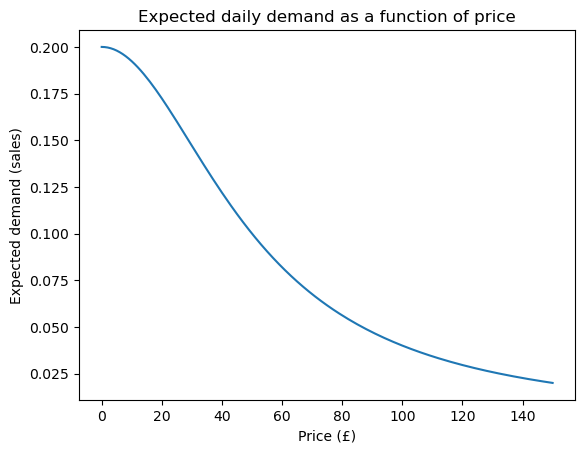

In [5]:
plt.plot(model.price_space, model.get_demand(model.price_space))
plt.title('Expected daily demand as a function of price')
plt.xlabel('Price (£)')
plt.ylabel('Expected demand (sales)')
plt.show()

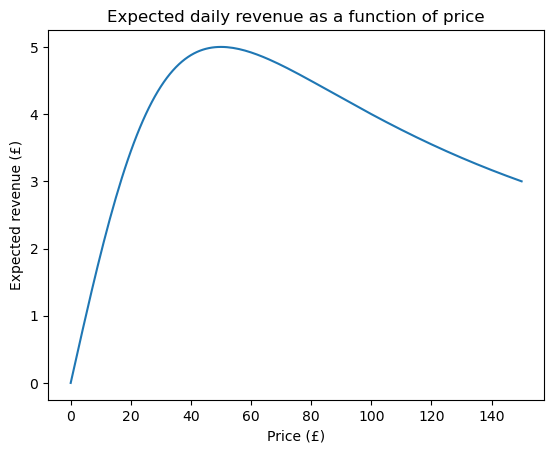

In [6]:
plt.plot(model.price_space, model.price_space * model.get_demand(model.price_space))
plt.title('Expected daily revenue as a function of price')
plt.xlabel('Price (£)')
plt.ylabel('Expected revenue (£)')
plt.show()

In [7]:
model.unconstrained_optimal_price()

50.0

In [8]:
model.get_demand(50)

0.1

# Pricing with capacity constraints

Consider having an inventory of 10 stock and 100 days to sell it all. We know that the price to maximise each day's revenue is £50. Furthermore, if we set £50 as the price the whole way, then we expect to sell everything, because we expect 10 sales over 100 days. This case is, intuitively, set up so that the optimal pricing strategy would be to set £50 for all 100 days, right? Well, no - wrong!

Let's look what to do today, 100 days out.

In [19]:
def observe(model, dtg, stock):
    qs = [model.q(dtg, stock, p) for p in model.price_space]
    value = model.v(dtg, stock)
    assert value == max(qs)
    price_opt = model.p(dtg, stock)
    dist = model.transition_distribution(stock, price_opt)
    E_demand = 0
    E_revenue = 0
    for (x, p) in zip(dist.support(), dist.get_probs()):
        E_demand += x*p
        E_revenue += price_opt * x * p
    print(f"Optimal price for today: £{price_opt}")
    print(f"Expected demand today at optimal price: {E_demand:.4f} sales")
    print(f"Expected revenue today at optimal price: £{E_revenue:.4f}")
    print(f"State value (i.e. max. expected total revenue) as of today: £{value:.4f}")
    print(f"Per item value today: £{value/stock:.4f}")
    plt.plot(model.price_space, qs)
    plt.xlabel('Price today (£)')
    plt.ylabel('Expected total revenue (£) under optimal pricing')
    plt.title("Value of setting today's price")
    plt.show()
    return

Optimal price for today: £62
Expected demand today at optimal price: 0.0788 sales
Expected revenue today at optimal price: £4.8865
State value (i.e. max. expected total revenue) as of today: £474.4577
Per item value today: £47.4458


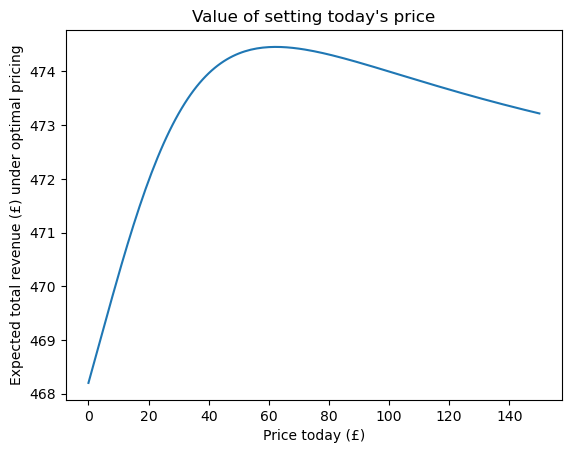

In [22]:
observe(model, 100, 10)

Wait, what?

This becomes clearer when we think about having 10 days to go, with only 1 item left in the inventory. Again, we would naively say that pricing for a sales rate of 0.1 would be best, especially since that price also maximises daily expected revenue.

However, once our single inventory item goes, it goes. Maximising expected daily revenue doesn't make much sense when there is no "long-term" for expectations to appear - we only have 10 days, and we only have one item! Instead, we have to think in terms of constrained time and inventory.

So we don't want to sell out our single stock item at 10 DTG - unless it's worth doing, in the sense of having lots of revenue! But we could take it to another extreme - why not price at £1M? That's because you'd be making the "in-case-of" revenue at 10 DTG impossible to actually achieve, so there is no potential revenue achievable from this pricing. You might as well just take it off sale for the day! 

The pricing strategy balances this trade-off between not wanting to sell out and wanting to maximise revenue.

Optimal price for today: £95
Expected demand today at optimal price: 0.0416 sales
Expected revenue today at optimal price: £3.9501
State value (i.e. max. expected total revenue) as of today: £34.2201
Per item value today: £34.2201


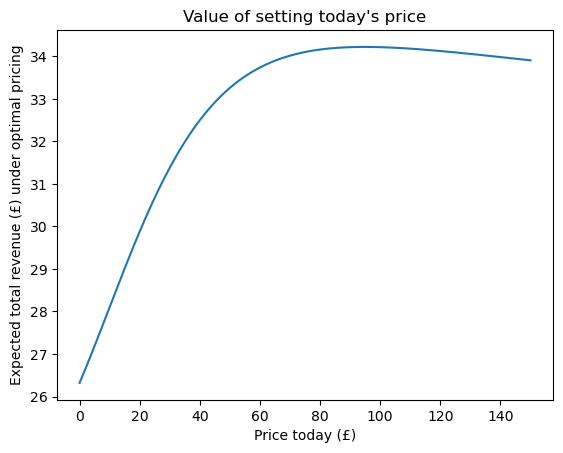

In [23]:
observe(model, 10, 1)

## Curves

Look again at 100 DTG with 10 stock remaining.

Optimal price for today: £62
Expected demand today at optimal price: 0.0788 sales
Expected revenue today at optimal price: £4.8865
State value (i.e. max. expected total revenue) as of today: £474.4577
Per item value today: £47.4458


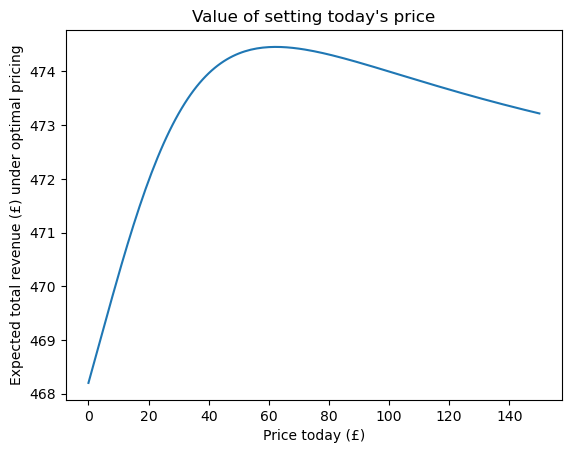

In [24]:
observe(model, 100, 10)

The revenue-optimal choice is to price for today such that demand is below that 0.1 baseline that would take us to fully sold. In fact, it looks like the £50 unconstrained optimal price acts as a minimum price in the constrained case. That is, when we have more stock than we can possibly sell then we're effectively back in the unconstrained case. So we don't discount *below* £50 because it's better to simply write off the unsold stock, for the purposes of revenue maximisation (although maybe there are situations where we should put marginal costs on unsold stock?)

Anyhoo, it would be interesting to see what this means for a booking curve using optimal pricing.

In [30]:
def next_state_distribution(model, dtg, stock, price=None):
    if dtg==0:
        return {}
    if stock==0:
        return {(dtg-1, 0): 1.0}
    if price is None:
        price = model.p(dtg, stock)
    dist = model.transition_distribution(stock, price)
    ps = dist.get_probs()
    return {(dtg-1, stock-x): ps[x] for x in range(stock+1)}

In [ ]:
next_state